# Maxcut problem

In [1]:
import numpy as np
import networkx as nx
from qiskit import *
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg'
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram as hist
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, QAOA
import math
from qiskit.aqua.components.optimizers import SLSQP, COBYLA
from qiskit.optimization.applications.ising import max_cut

In [2]:
import warnings
warnings.filterwarnings('ignore')

### The graph has  n=5  vertices  V={0,1,2,3,4,5}  and six edges  E={(0,1),(0,2),(1,2),(3,2),(3,4),(4,2)} , which will all carry the same unit weight  wij=1

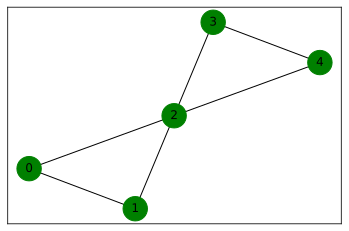

In [3]:
n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['g' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [4]:
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0.]]


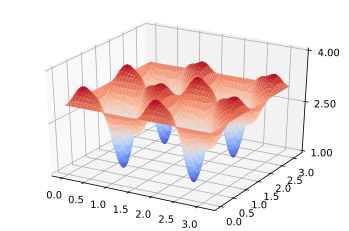


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.432
This is attained for gamma = 1.230 and beta = 1.370


In [5]:
# Evaluate the function
step_size   = 0.01;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1=3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

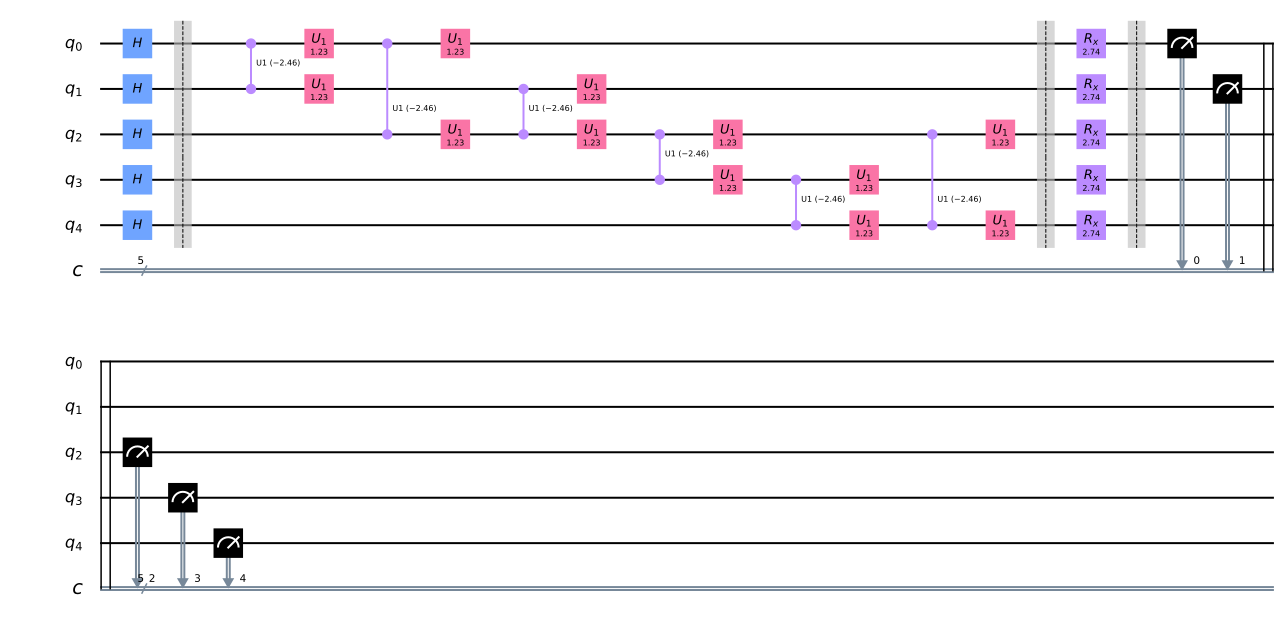

In [6]:
# prepare the quantum and classical resisters
qaoa_qc = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
qaoa_qc.h(range(len(V)))
qaoa_qc.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    qaoa_qc.cu1(-2*gamma, k, l)
    qaoa_qc.u1(gamma, k)
    qaoa_qc.u1(gamma, l)
    
# then apply the single qubit X - rotations with angle beta to all qubits
qaoa_qc.barrier()
qaoa_qc.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis
qaoa_qc.barrier()
qaoa_qc.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
qaoa_qc.draw(output='mpl')

In [7]:
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

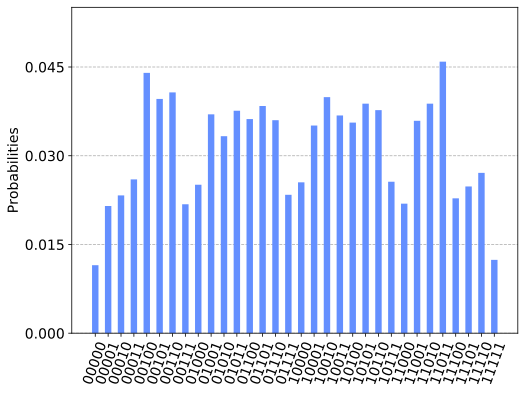

In [8]:
from qiskit.visualization import plot_histogram
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(qaoa_qc, backend=backend, shots=shots)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.33 while the true value is M1 = 3.43 

The approximate solution is x* = 11010 with C(x*) = 4 

The cost function is distributed as: 



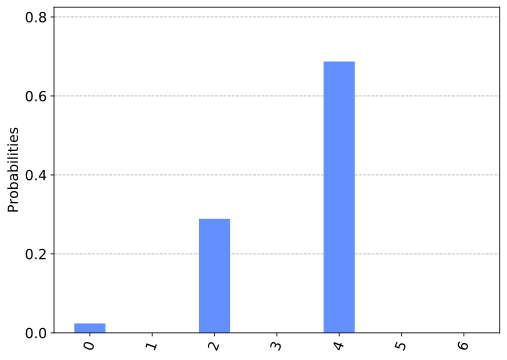

In [9]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

In [10]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

In [11]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [12]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmqx2


In [13]:
shots   = 2048
job_exp = execute(qaoa_qc, backend=backend, shots=shots)
job_monitor(job_exp)

Job Status: job has successfully run


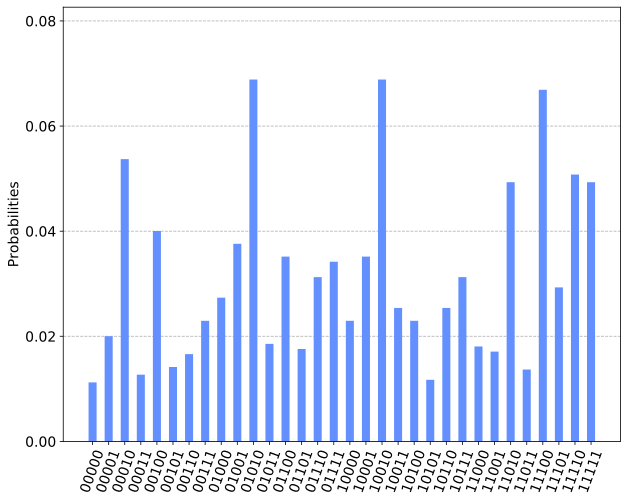

In [14]:
exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (10,8),bar_labels = False)

In [15]:
counts = exp_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots


 --- EXPERIMENTAL RESULTS ---

The sampled mean value is M1_sampled = 2.98 while the true value is M1 = 3.43 

The approximate solution is x* = 11010 with C(x*) = 4 

The cost function is distributed as: 



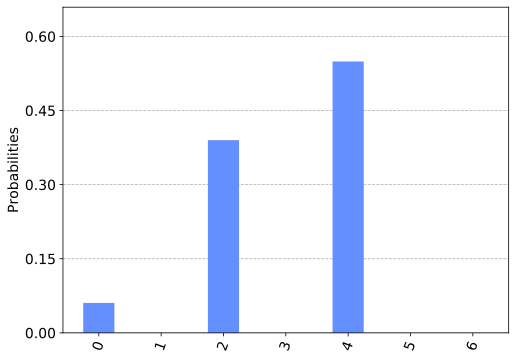

In [16]:
print('\n --- EXPERIMENTAL RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

# Another way

In [17]:
qubitOp, offset = max_cut.get_operator(w)

In [18]:
# Create the initial parameters
backend = BasicAer.get_backend('qasm_simulator')
seed = 50

optimizer = SLSQP(maxiter=250)
qaoa = QAOA(qubitOp, optimizer, 1)

qaoa.random_seed = seed

In [19]:
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
result = qaoa.run(quantum_instance)

Energy: 0.54296875
Time: 0.1894669532775879
Max-cut objective: -2.45703125
Solution: [1 1 1 1 1]
Solution objective: 0.0


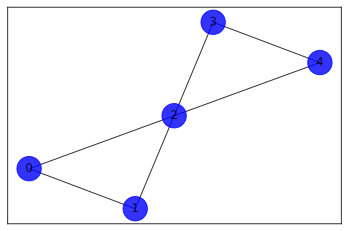

In [20]:
x = sample_most_likely(result.eigenstate)
print('Energy:', result.eigenvalue.real)
print('Time:', result.optimizer_time)
print('Max-cut objective:', result.eigenvalue.real + offset)
print('Solution:', max_cut.get_graph_solution(x))
print('Solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

In [21]:
# Create the initial parameters
backend = BasicAer.get_backend('statevector_simulator')
seed = 50

optimizer = COBYLA(maxiter=250)
qaoa = QAOA(qubitOp, optimizer, 1)

qaoa.random_seed = seed
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
result = qaoa.run(quantum_instance)

Energy: -0.92876445635512
Time: 0.39177656173706055
Max-cut objective: -3.92876445635512
Solution: [0. 1. 0. 0. 1.]
Solution objective: 4.0


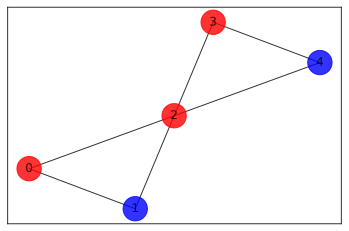

In [22]:
x = sample_most_likely(result.eigenstate)
print('Energy:', result.eigenvalue.real)
print('Time:', result.optimizer_time)
print('Max-cut objective:', result.eigenvalue.real + offset)
print('Solution:', max_cut.get_graph_solution(x))
print('Solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

In [23]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2020-07-06 17:56:19,263: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmqx2


In [24]:
seed = 50
optimizer = SLSQP(maxiter=10,disp=True,ftol=0.2)
qaoa = QAOA(qubitOp, optimizer, 1)
qaoa.random_seed = seed
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
result = qaoa.run(quantum_instance)

The skip Qobj validation does not work for IBMQ provider. Disable it.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.021484375
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1


Energy: -0.021484375
Time: 57.19123816490173
Max-cut objective: -3.021484375
Solution: [0 1 1 0 1]
Solution objective: 4.0


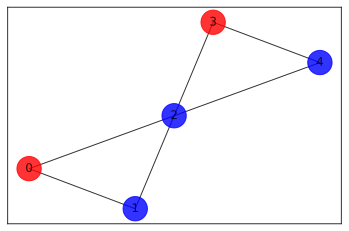

In [25]:
x = sample_most_likely(result.eigenstate)
print('Energy:', result.eigenvalue.real)
print('Time:', result.optimizer_time)
print('Max-cut objective:', result.eigenvalue.real + offset)
print('Solution:', max_cut.get_graph_solution(x))
print('Solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

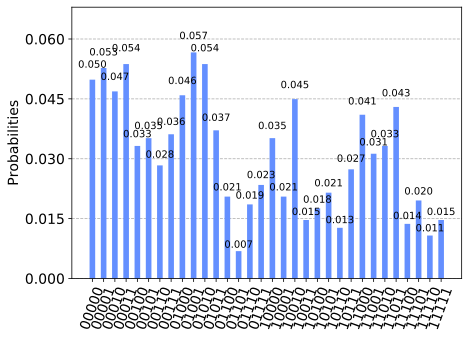

In [26]:
from qiskit.visualization import plot_histogram
plot_histogram(result.eigenstate)